In [1]:
# Packages
import sys; sys.path.append('../')
import tqdm
import pandas as pd
import bnlearn as bn
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from statsmodels.tsa.seasonal import seasonal_decompose
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
import torchvision
import warnings
warnings.filterwarnings("ignore")
from src.functions.loss.norm import norm,downsample
import argparse

import dgl
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.autograd import Variable
from tqdm import tqdm


C:\Users\Dell\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Dell\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
Using backend: pytorch


In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
device

device(type='cpu')

In [3]:
test = pd.read_csv("SWaT_Dataset_Attack_v0.csv", index_col=0)
train = pd.read_csv("SWaT_Dataset_Normal_v1.csv", index_col=0)
train.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
22/12/2015 4:30:00 PM,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
22/12/2015 4:30:01 PM,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
22/12/2015 4:30:02 PM,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
22/12/2015 4:30:03 PM,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
22/12/2015 4:30:04 PM,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal


In [4]:
train['attack'].replace('Normal', 0, inplace=True)
train['attack'].replace('Attack', 1, inplace=True) 
train['attack'].replace('A ttack', 1, inplace=True) 
test['attack'].replace('Normal', 0, inplace=True) 
test['attack'].replace('Attack', 1, inplace=True) 
test['attack'].replace('A ttack', 1, inplace=True)

In [5]:
non_floats = []
for col in train:
    if train[col].dtypes != "float64":
        non_floats.append(col)
non_floats = non_floats[:-1]
train =train.drop(columns=non_floats,axis=1)
train

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
22/12/2015 4:30:00 PM,0.000000,124.3135,251.9226,8.313446,312.7916,0.000000,2.560983,0.000256,138.5061,0.000,...,123.31450,0.001538,0.001409,0.001664,0.000000,9.100231,0.000000,3.3485,0.000256,0
22/12/2015 4:30:01 PM,0.000000,124.3920,251.9226,8.313446,312.7916,0.000000,2.560983,0.000256,138.7465,0.000,...,123.31450,0.001538,0.001409,0.001664,0.000000,9.100231,0.000000,3.3485,0.000256,0
22/12/2015 4:30:02 PM,0.000000,124.4705,251.9226,8.313446,312.7916,0.000000,2.560983,0.000256,138.6263,0.000,...,123.31450,0.001538,0.001409,0.001664,0.000000,9.100231,0.000000,3.3485,0.000256,0
22/12/2015 4:30:03 PM,0.000000,124.6668,251.9226,8.313446,312.7916,0.000000,2.560983,0.000256,138.7064,0.000,...,123.31450,0.001538,0.001409,0.001664,0.000000,9.100231,0.000000,3.3485,0.000256,0
22/12/2015 4:30:04 PM,0.000000,124.5098,251.9226,8.313446,312.7916,0.000000,2.560983,0.000256,138.9067,0.000,...,123.31450,0.001538,0.001409,0.001664,0.000000,9.100231,0.000000,3.3485,0.000256,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28/12/2015 9:59:55 AM,2.460366,523.0430,262.0161,8.396437,328.5055,2.442316,19.748380,2.212087,955.8046,148.808,...,12.03538,1.726352,1.292430,0.735269,0.308619,250.817100,1.778105,189.8552,0.000128,0
28/12/2015 9:59:56 AM,2.448836,522.9645,262.0161,8.396437,328.5055,2.442316,19.748380,2.210037,955.8847,148.808,...,12.03538,1.724942,1.281158,0.735269,0.308619,250.817100,1.778105,189.5027,0.000128,0
28/12/2015 9:59:57 AM,2.434744,522.8860,262.0161,8.396437,328.6337,2.444879,19.748380,2.207731,955.9648,148.808,...,12.03538,1.723789,1.272576,0.735269,0.308619,250.817100,1.778105,189.5027,0.000128,0


In [6]:
non_floats = []
for col in test:
    if test[col].dtypes != "float64":
        non_floats.append(col)
non_floats = non_floats[:-1]
test =test.drop(columns=non_floats,axis=1)
test

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
28/12/2015 10:00:00 AM,2.427057,522.8467,262.0161,8.396437,328.6337,2.445391,19.74838,2.206835,956.1651,148.8080,...,12.03538,1.723789,1.279621,0.735269,0.307786,250.8652,1.649953,189.5988,0.000128,0
28/12/2015 10:00:01 AM,2.446274,522.8860,262.0161,8.396437,328.6337,2.445391,19.74838,2.208244,956.1651,148.8080,...,12.03538,1.723789,1.297554,0.735269,0.307786,250.8652,1.649953,189.6789,0.000128,0
28/12/2015 10:00:02 AM,2.489191,522.8467,262.0161,8.394514,328.6337,2.442316,19.69076,2.208628,956.4855,148.8080,...,12.03538,1.723404,1.293967,0.735269,0.308619,250.8812,1.649953,189.6789,0.000128,0
28/12/2015 10:00:03 AM,2.534350,522.9645,262.0161,8.394514,328.6337,2.442316,19.69076,2.208628,956.8060,148.8080,...,12.03538,1.723404,1.281158,0.735269,0.308619,250.8812,1.649953,189.6148,0.000128,0
28/12/2015 10:00:04 AM,2.569260,523.4748,262.0161,8.394514,328.6337,2.443085,19.69076,2.208628,957.0864,148.8080,...,12.03538,1.723404,1.281158,0.735269,0.308619,250.8812,1.649953,189.5027,0.000128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/1/2016 2:59:55 PM,2.559972,519.5495,168.0979,8.638683,301.9226,2.459488,20.39823,2.196586,974.5498,148.8032,...,14.80390,1.716483,1.288971,0.734885,0.306569,251.1535,0.865024,189.0220,0.000000,0
2/1/2016 2:59:56 PM,2.549082,520.4131,168.0979,8.638683,301.9226,2.459488,20.39823,2.196586,974.5898,148.8032,...,14.80390,1.714560,1.272704,0.734885,0.306569,251.0734,0.865024,188.9259,0.000000,0
2/1/2016 2:59:57 PM,2.531467,520.6878,168.0979,8.638683,301.9226,2.460129,20.33101,2.195561,974.2695,148.8032,...,14.80390,1.714560,1.269502,0.734885,0.306569,251.0734,0.865024,188.9259,0.000000,0


In [7]:
# max min(0-1)
def norm(train, test):
    from sklearn.preprocessing import normalize
    from sklearn.preprocessing import MinMaxScaler

    normalizer = MinMaxScaler(feature_range=(0, 1)).fit(train) # scale training data to [0,1] range
    train_ret = normalizer.transform(train)
    test_ret = normalizer.transform(test)

    return train_ret, test_ret

# downsample by 10
def downsample(data, labels, down_len):
    np_data = np.array(data)
    np_labels = np.array(labels).astype(int)

    orig_len, col_num = np_data.shape

    down_time_len = orig_len // down_len

    np_data = np_data.transpose()

    d_data = np_data[:, :down_time_len*down_len].reshape(col_num, -1, down_len)
    d_data = np.median(d_data, axis=2).reshape(col_num, -1)

    d_labels = np_labels[:down_time_len*down_len].reshape(-1, down_len)
    # if exist anomalies, then this sample is abnormal
    d_labels = np.round(np.max(d_labels, axis=1))


    d_data = d_data.transpose()

    return d_data.tolist(), d_labels.tolist()

## Downsampling

In [8]:

    test = test.iloc[:, 1:]
    train = train.iloc[:, 1:]


    train = train.fillna(0)
    test = test.fillna(0)

    # trim column names
    train = train.rename(columns=lambda x: x.strip())
    test = test.rename(columns=lambda x: x.strip())

    # print(len(test.columns),test.columns)
    # print(len(train.columns),train.columns)


    train_labels = train.attack
    test_labels = test.attack

    train = train.drop(columns=['attack'])
    test = test.drop(columns=['attack'])


    x_train, x_test = norm(train.values, test.values)


    for i, col in enumerate(train.columns):
        train.loc[:, col] = x_train[:, i]
        test.loc[:, col] = x_test[:, i]


    d_train_x, d_train_labels = downsample(train.values, train_labels, 10)
    d_test_x, d_test_labels = downsample(test.values, test_labels, 10)

    train_df = pd.DataFrame(d_train_x, columns = train.columns)
    test_df = pd.DataFrame(d_test_x, columns = test.columns)

    test_df['attack'] = d_test_labels
    train_df['attack'] = d_train_labels

    train_df = train_df.iloc[2160:]


In [9]:
train_df.to_csv('./train.csv')
test_df.to_csv('./test.csv')

In [10]:
features = ['LIT301', 'AIT203', 'AIT202']
features = train_df[features]
print(features.head())

        LIT301    AIT203    AIT202
2160  0.969888  0.707232  0.931928
2161  0.970410  0.718534  0.921388
2162  0.971296  0.727122  0.916995
2163  0.971546  0.735861  0.916995
2164  0.973794  0.743044  0.916995


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

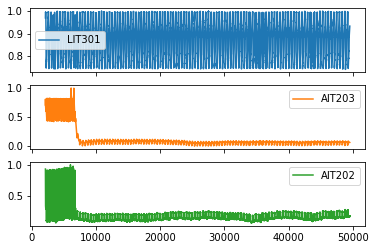

In [11]:
features.plot(subplots=True)

## preprocess features

(92331, 25)


<AxesSubplot:title={'center':'Label Frequency for attack label in Dataset'}>

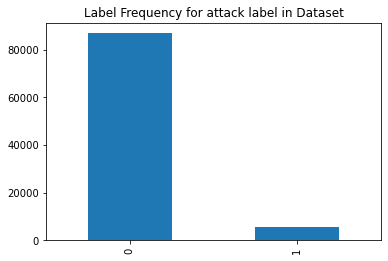

In [12]:
df = pd.concat([train_df,test_df])
print(df.shape)
df.attack.value_counts().plot(kind='bar', title='Label Frequency for attack label in Dataset')

In [ ]:
df.info()

## Structure learning

In [14]:
model_learned = bn.structure_learning.fit(df.iloc[:1000,:],methodtype='hc',scoretype='bic')

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]


[bnlearn] >Plot based on BayesianModel


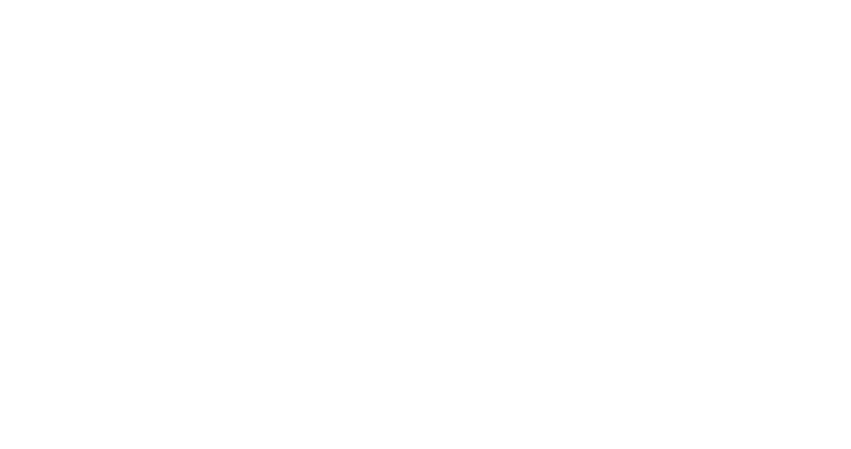

{'pos': {'LIT101': array([-0.39651491,  0.83564856]),
  'AIT201': array([0.35312509, 0.91590754]),
  'AIT202': array([-0.88276572, -0.15381772]),
  'AIT203': array([0.92942112, 0.45256262]),
  'FIT201': array([ 0.04358809, -0.94498074]),
  'DPIT301': array([0.42968305, 0.70165024]),
  'FIT301': array([-0.60273037, -0.83676769]),
  'LIT301': array([-0.89910339, -0.40094238]),
  'AIT401': array([ 0.90327264, -0.47132793]),
  'AIT402': array([-0.7302138 , -0.59964136]),
  'FIT401': array([-0.16246173,  0.91065046]),
  'LIT401': array([ 0.26823665, -0.84787059]),
  'AIT501': array([0.06124165, 1.        ]),
  'AIT502': array([-0.22920643, -0.9339099 ]),
  'AIT503': array([0.81899479, 0.30479764]),
  'AIT504': array([-0.62380352,  0.73743354]),
  'FIT501': array([-0.36986189, -0.71713374]),
  'FIT502': array([ 0.71654912, -0.67610157]),
  'FIT503': array([-0.82903257,  0.55862931]),
  'FIT504': array([-0.93734892,  0.08514423]),
  'PIT501': array([0.68860513, 0.71799992]),
  'PIT502': array

In [15]:
bn.plot(model_learned)

## ADJACENCY MATRIX

In [16]:
vector = bn.adjmat2vec(model_learned['adjmat'])
A=(model_learned['adjmat'])
A = A.astype(int)
A.head(5)
A


target,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,AIT402,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,attack
source,,,,,,,,,,,,,,,,,,,,,
LIT101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIT201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIT202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIT203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FIT201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DPIT301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FIT301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LIT301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIT401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
n_sensor = len(df.columns[:-1])
n_sensor

24

In [25]:
norm_feature = df.iloc[:,:-1]

In [26]:
train_df = norm_feature.iloc[:int(0.6*len(df))]
train_label = df.attack.iloc[:int(0.6*len(df))]

val_df = norm_feature.iloc[int(0.6*len(df)):int(0.8*len(df))]
val_label = df.attack.iloc[int(0.6*len(df)):int(0.8*len(df))]

test_df = norm_feature.iloc[int(0.8*len(df)):]
test_label = df.attack.iloc[int(0.8*len(df)):]

In [27]:
train_loader = DataLoader((train_df,train_label), batch_size=64, shuffle=True)
val_loader = DataLoader((val_df,val_label), batch_size=64,shuffle=False)
test_loader = DataLoader((test_df,test_label), batch_size=64, shuffle=False)

In [28]:
from torch.nn.init import xavier_uniform_
init = torch.zeros([n_sensor, n_sensor])
init = xavier_uniform_(init).abs()
init = init.fill_diagonal_(0.0)
A = torch.tensor(init, requires_grad=True, device=device)
A

tensor([[0.0000, 0.2339, 0.3502, 0.0364, 0.1909, 0.0057, 0.1778, 0.2989, 0.0791,
         0.2315, 0.2007, 0.1563, 0.3241, 0.0562, 0.2418, 0.2163, 0.2009, 0.3036,
         0.2227, 0.0580, 0.0597, 0.1242, 0.2727, 0.1348],
        [0.1103, 0.0000, 0.0059, 0.0707, 0.2256, 0.2033, 0.2048, 0.0310, 0.2983,
         0.2229, 0.0914, 0.0115, 0.1454, 0.0199, 0.1763, 0.1915, 0.0492, 0.0269,
         0.3439, 0.1727, 0.3436, 0.0110, 0.2769, 0.0163],
        [0.0053, 0.0154, 0.0000, 0.2143, 0.2055, 0.1103, 0.0298, 0.2312, 0.0234,
         0.3473, 0.2157, 0.2683, 0.1097, 0.0261, 0.1346, 0.1887, 0.3265, 0.1858,
         0.0664, 0.3261, 0.1571, 0.0989, 0.0220, 0.1440],
        [0.0901, 0.1707, 0.1345, 0.0000, 0.0932, 0.2524, 0.2480, 0.1166, 0.2358,
         0.3296, 0.0791, 0.2521, 0.3267, 0.0687, 0.0757, 0.1676, 0.2008, 0.2650,
         0.1459, 0.2106, 0.1836, 0.1550, 0.0724, 0.0357],
        [0.0074, 0.0177, 0.1347, 0.0052, 0.0000, 0.0432, 0.2479, 0.0402, 0.0756,
         0.2705, 0.3445, 0.0843, 0.0130

In [29]:
import torch
import torch.nn as nn
from functools import partial

class RecurrentEncoder(nn.Module):
    """Recurrent encoder"""

    def __init__(self, n_features, latent_dim, rnn):
        super().__init__()

        self.rec_enc1 = rnn(n_features, latent_dim, batch_first=True)

    def forward(self, x):
        _, h_n = self.rec_enc1(x)

        return h_n

class RecurrentDecoder(nn.Module):
    """Recurrent decoder for RNN and GRU"""

    def __init__(self, latent_dim, n_features, rnn_cell, device):
        super().__init__()

        self.n_features = n_features
        self.device = device
        self.rec_dec1 = rnn_cell(n_features, latent_dim)
        self.dense_dec1 = nn.Linear(latent_dim, n_features)

    def forward(self, h_0, seq_len):
        # Initialize output
        x = torch.tensor([], device = self.device)

        # Squeezing
        h_i = h_0.squeeze()

        # Reconstruct first element with encoder output
        x_i = self.dense_dec1(h_i)

        # Reconstruct remaining elements
        for i in range(0, seq_len):
            h_i = self.rec_dec1(x_i, h_i)
            x_i = self.dense_dec1(h_i)
            x = torch.cat([x, x_i], axis=1)

        return x.view(-1, seq_len, self.n_features)


class RecurrentDecoderLSTM(nn.Module):
    """Recurrent decoder LSTM"""

    def __init__(self, latent_dim, n_features, rnn_cell, device):
        super().__init__()

        self.n_features = n_features
        self.device = device
        self.rec_dec1 = rnn_cell(n_features, latent_dim)
        self.dense_dec1 = nn.Linear(latent_dim, n_features)

    def forward(self, h_0, seq_len):
        # Initialize output
        x = torch.tensor([], device = self.device)

        # Squeezing
        h_i = [h.squeeze() for h in h_0]

        # Reconstruct first element with encoder output
        x_i = self.dense_dec1(h_i[0])

        # Reconstruct remaining elements
        for i in range(0, seq_len):
            h_i = self.rec_dec1(x_i, h_i)
            x_i = self.dense_dec1(h_i[0])
            x = torch.cat([x, x_i], axis = 1)

        return x.view(-1, seq_len, self.n_features)


class RecurrentAE(nn.Module):
    """Recurrent autoencoder"""

    def __init__(self, n_features, latent_dim, device):
        super().__init__()

        # Encoder and decoder argsuration
        self.rnn, self.rnn_cell = nn.LSTM, nn.LSTMCell
        self.decoder = RecurrentDecoderLSTM
        self.latent_dim = latent_dim
        self.n_features = n_features
        self.device = device

        # Encoder and decoder
        self.encoder = RecurrentEncoder(self.n_features, self.latent_dim, self.rnn)
        self.decoder = self.decoder(self.latent_dim, self.n_features, self.rnn_cell, self.device)

    def forward(self, x):
        # x: N X K X L X D 
        seq_len = x.shape[1]
        h_n = self.encoder(x)
        out = self.decoder(h_n, seq_len)

        return torch.flip(out, [1])


In [31]:
n_features = n_sensor
latent_dim = 12
device 

device(type='cpu')

In [35]:
model = RecurrentAE(n_features, latent_dim, device)
model = model.to(device)


In [43]:
loss_best = 100
epoch = 100

In [44]:
for _ in range(epoch):

        # train iteration
        loss_train = []
        epoch += 1
        model.train()
        for x in train_loader:
            x = x.to(device)

            optimizer.zero_grad()
            loss = -model(x,  A)
            h = torch.trace(torch.matrix_exp( A* A)) - n_sensor
            total_loss = loss + 0.5 * rho * h * h + alpha * h

            total_loss.backward()
            clip_grad_value_(model.parameters(), 1)
            optimizer.step()
            loss_train.append(loss.item())
            A.data.copy_(torch.clamp(A.data, min=0, max=1))


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.frame.DataFrame'>

## 1D Convolution

In [ ]:
# Simple Conv
# Here we borrow method from sklearn
def conv(data):
    result = [] 
    for i in range(25):
        sample = data.iloc[:, i]
        sd = seasonal_decompose(sample, period=1000, extrapolate_trend='freq').trend
        result.append(sd)
    result = np.transpose(np.array(result), (1, 0))
    return result